<a href="https://colab.research.google.com/github/HzcIrving/Deep-Learning-for-myself/blob/master/HZC_image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###工作顺序
- 可视化数据/执行一些探索性的数据分析
- 设置数据pipeline以及预处理
- 搭建模型
- 训练模型
- 评估模型
- 重复

In [0]:
! pip install kaggle

In [0]:
import os 
import glob   # 类似于Windows下的文件搜索
import zipfile 
import functools  # 高阶函数 

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rcParams['axes.grid'] = False  # 没有网格
mpl.rcParams['figure.figsize'] = (12,12) # 图像大小统一化

from sklearn.model_selection import train_test_split # 训练测试集划分
import matplotlib.image as mpimg # 图像可视化
import pandas as pd 
from PIL import Image
% matplotlib inline 

import tensorflow as tf 
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers,losses,models
from tensorflow.python.keras import backend as K 

### 获取所有的文件
由于我们需要使用Kaggle里的数据集，这需要我们创建一个API token为你的kaggle账户，然后上载它

In [0]:
import os

# 上传API令牌.
def get_kaggle_credentials():
  """获取kaggle授权"""
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()


Saving kaggle.json to kaggle.json


现在可以进行kaggle模块的导入了

In [0]:
import kaggle

### 下面就是进行从Kaggle上下载数据集
注意:
- 这个数据集的下载会消耗大概14G的磁盘空间
- 你必须接收**[竞赛规则](https://www.kaggle.com/c/carvana-image-masking-challenge/rules)**，在你下载数据之前；

In [0]:
competition_name = 'carvana-image-masking-challenge'

# 下载数据并解压
def load_data_from_zip(competition,file):
  """解压压缩包来读取数据"""
  with zipfile.ZipFile(os.path.join(competition,file),"r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
  """数据下载"""
#   kaggle.api.competition_download_files(competition,competition)
  load_data_from_zip(competition,'train.zip')
  print("training datasets download completed...")
  load_data_from_zip(competition,'train_masks.zip')
  print("trian_masks.zip downloaded completed...")
  load_data_from_zip(competition,'train_masks.csv.zip')
  print("train_masks.csv.zip downloaded completed...")
  

In [0]:
# get_data(competition_name) # 下载
# load_data_from_zip(competition,'train.zip')
# print("training datasets 下载完成...")
# load_data_from_zip(competition,'train_masks.zip')
# print("trian_masks.zip 下载完成...")
# load_data_from_zip(competition,'train_masks.csv.zip')
# print("train_masks.csv.zip 下载完成...")

In [0]:
img_dir = os.path.join(competition_name,"train") # 图片路径
label_dir = os.path.join(competition_name,"train_masks") # mask label的路径
train_mask_csv = os.path.join(competition_name,"train_masks.csv")

print(img_dir+'\n') 
print(label_dir+'\n')
print(train_mask_csv+'\n')

df_train = pd.read_csv(train_mask_csv) 
print(df_train.head())
print(df_train.shape)

# 取出各个图片的索引名
ids_train = df_train['img'].map(lambda s:s.split('.')[0]) 
print(ids_train.head())
print(ids_train.shape)

carvana-image-masking-challenge/train

carvana-image-masking-challenge/train_masks

carvana-image-masking-challenge/train_masks.csv

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...
(5088, 2)
0    00087a6bd4dc_01
1    00087a6bd4dc_02
2    00087a6bd4dc_03
3    00087a6bd4dc_04
4    00087a6bd4dc_05
Name: img, dtype: object
(5088,)


In [0]:
x_train_filenames = []
y_train_filenames = []

for img_id in ids_train:
  # 每一张图片：XXX.jpg ，添加训练集列表
  x_train_filenames.append(os.path.join(img_dir,"{}.jpg".format(img_id)))
  # 每一张图片的label名称：XXX_mask.gif，添加训练集label列表
  y_train_filenames.append(os.path.join(label_dir,"{}_mask.gif".format(img_id)))

# 进行数据集、测试集、验证集划分
x_train_filenames,\
x_val_filenames,\
y_train_filenames,\
y_val_filenames, = train_test_split(x_train_filenames,
                                    y_train_filenames,
                                    test_size = 0.2,
                                    random_state = 42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("训练集数量：{}".format(num_train_examples))
print("验证集数量：{}".format(num_val_examples))
print("*"*50+"\n")


训练集数量：4070
验证集数量：1018
**************************************************



In [0]:
# 这是路径的样子 注意后缀
x_train_filenames[:10]

['carvana-image-masking-challenge/train/69915dab0755_16.jpg',
 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg',
 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg',
 'carvana-image-masking-challenge/train/562706000bd7_15.jpg',
 'carvana-image-masking-challenge/train/917f262f1608_06.jpg',
 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg',
 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg',
 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg',
 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg',
 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']

In [0]:
y_train_filenames[:10]

['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif',
 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif',
 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif',
 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif',
 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif',
 'carvana-image-masking-challenge/train_masks/fce0ba5b8ed7_07_mask.gif',
 'carvana-image-masking-challenge/train_masks/93881caf9f70_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/eb07e3f63ad2_09_mask.gif',
 'carvana-image-masking-challenge/train_masks/78bfb9c780db_10_mask.gif',
 'carvana-image-masking-challenge/train_masks/d3d0d2662918_12_mask.gif']

### 可视化Visualize
让我们先来看几张数据集中的例子

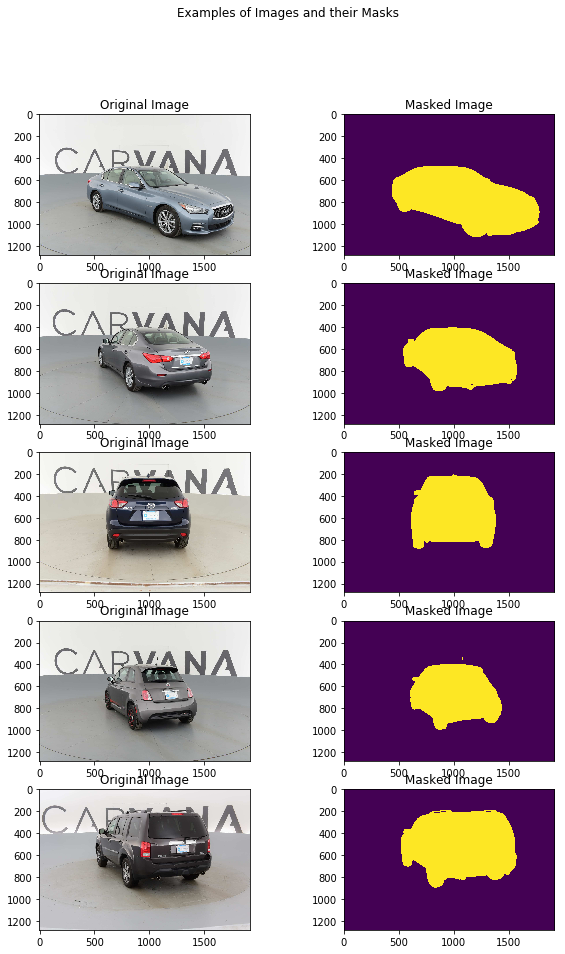

In [0]:
display_num = 5 # 显示例子数量
r_choices = np.random.choice(num_train_examples,display_num) # 随机选择

plt.figure(figsize=(10,15))
for i in range(0,display_num*2,2):
  img_num = r_choices[i//2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num,2,i+1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  labels_vals = np.unique(example_labels) # 查找数组的唯一元素。
  
  plt.subplot(display_num,2,i+2)
  plt.imshow(example_labels)
  plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()


### 设置
- standard & resize所有图片的形状
- 设置一些训练的超参数
- 由于UNet版本的问题，因为我们对每MaxPooling2Dlayer的空间分辨率进行采样时，必须将其除以2倍。（当然，使用高分辨率的效果会更好）
- 如果计算机无法承受，可以选择降低分辨率与batch_size

In [0]:
# 训练超参数
img_shape = (256,256,3)
batch_size = 3
epochs = 5 

### 使用tf.data来搭建你的input pipeline 
- 由于我们从文件名开始，我们将需要构建一个健壮的、可伸缩的数据pipeline，它将很好地与我们的模型配合使用。<br>

### 我们的input pipeline构建由下面几步组成：
1.  从文件名中读取文件的字节（包括图像与标签），回想一下，我们的标签实际上是图像，像素级的annotation——每个像素都注释为car或者background(1,0)；
2. 将字节解码成图像格式；
3. 应用图像变形（根据输入超参数）
  -  resize - 将图片变换到标准尺寸；
    - 进行这一步的原因是：UNet是全卷积神经网络的网络（没有FC全连接层），所以不依赖于输入尺寸，但是，如果你不选择去resize你的图片，你需要将你的batchsize 参数设置为1，**因为你不能将不同的尺寸batch到一起**。
    - 或者，您也可以将图像**存储bucket**在一起，并在每个小批中调整它们的大小，以尽可能避免调整图像的大小，**因为调整大小可能会通过插值等影响性能**。
  - hue_delta - 通过一个random factor来调整RGB图像的hue（色调）值。这只用在我们的实际图像中（label 图像不适用）。其值的范围在[0,0.5]
  - horizontal_flip - 水平翻转图像（概率0.5)，对实际图像与label图像同时进行翻转（否则影响训练效果）
  - width_shift_range & height_shift_range - 随机平移图像水平或垂直。需要对label和实际图像同时进行。
  - rescale - 按一定的比例缩放图像；e.g.1/255
4. 打乱数据，批量化数据，重复数据，预读取数据（提高效率）

注意，这些transformations的tricks必须是symbolic转换.

####为什么我们需要进行这些变化呢？
这被叫做**数据增强**，这个操作通过随机变换图像，来增强模型的泛化能力，避免过拟合的发生。
  



In [0]:
# 处理每个路径名
def _process_pathname(fname,label_path):
  """将处理路径函数映射到每个路径名对"""
  # 读取原图像文件字符
  img_str = tf.read_file(filename=fname)
  img = tf.image.decode_jpeg(img_str,channels=3) # 解码成图像数据
  
  # 读取label文件字符
  label_img_str = tf.read_file(label_path) 
  # 这些是gif图像，解码后返回(num_frames,h,w,c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # label图像，与二分类图像不同，每一个像素都有相应的0和1(car or background)
  label_img = label_img[:,:,0]
#   print("拓宽维度前：{}".format(label_img.shape))
  label_img = tf.expand_dims(label_img,axis=-1)
#   print("拓宽维度后：{}".format(label_img.shape))
  
  return img,label_img

In [0]:
# 平移图像
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """这个函数对图像进行垂直与水平平移"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # 无论是actual图像，还是label图像，需要同时进行变换
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

In [0]:
# 随机翻转
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5), # 0.5的可能行进行随机翻转 
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [0]:
# 将上面的变换进行集成，集成到数据增强函数
def _augment(img,
              label_img,
              resize = None, # 进行resize操作，eg. [256,256]
              scale = 1, # 中心化图像 eg.1/255)
              hue_delta=0, # 调整色度
              horizontal_flip = False, # 是否随机翻转
              width_shift_range = 0, # 平移宽度阈值范围
              height_shift_range = 0,# 平移长度阈值范围
             ):
  if resize is not None:
    # resize操作
    label_img = tf.image.resize_images(label_img,resize)
    img = tf.image.resize_images(img,resize)
  
  if hue_delta:
    img = tf.image.random_hue(img,hue_delta)
    
  img,label_img = flip_img(horizontal_flip,img,label_img)
  img,label_img = shift_img(img,label_img,width_shift_range,height_shift_range)
  
  # scale 中心化
  label_img = tf.to_float(label_img)*scale
  img = tf.to_float(img)*scale
  return img,label_img  

In [0]:
# shuffle,batch,repeat,prefetch..操作来增加数据泛化能力
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),# 预处理函数
                         threads=5, # 线程数
                         batch_size = batch_size,
                         shuffle = True):
  num_x = len(filenames) 
  
  # 通过filename和label来创建数据集
  dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))
  
  # 将预处理函数映射到datase中的每个元素
  # 充分利用多线程的优势
  dataset = dataset.map(_process_pathname,num_parallel_calls = threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "因为进行batch的图片必须统一大小"
  
  dataset = dataset.map(preproc_fn,num_parallel_calls=threads)
  
  if shuffle:# 是否随机打乱 
    dataset = dataset.shuffle(num_x)
  
  # 有必要对所有的epochs重复我们的数据
  dataset = dataset.repeat().batch(batch_size)
  return dataset
  

### 设置训练与验证集
注意，我们只在训练集中使用数据增强，验证集无需使用；

In [0]:
tr_cfg = {
    'resize':[img_shape[0],img_shape[1]],
    'scale':1/255.,
    'hue_delta':0.1,
    'horizontal_flip':True,
    'width_shift_range':0.1,
    'height_shift_range':0.1,
} # 训练集参数组
tr_preprocessing_fn = functools.partial(_augment,**tr_cfg)

val_cfg = {
    'resize':[img_shape[0],img_shape[1]],
    'scale':1/255.,
} # 验证集参数组
val_preprocessing_fn = functools.partial(_augment,**val_cfg)

train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn = tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames,
                              preproc_fn = val_preprocessing_fn,
                              batch_size = batch_size)

拓宽维度前：(?, ?)
拓宽维度后：(?, ?, 1)


W0615 10:31:22.367281 140609060546432 deprecation.py:323] From <ipython-input-61-ace40f812995>:22: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


拓宽维度前：(?, ?)
拓宽维度后：(?, ?, 1)


### 我们来看一下，数据增强是否达到了预期的效果

In [0]:
temp_ds = get_baseline_dataset(x_train_filenames,
                               y_train_filenames,
                               preproc_fn = tr_preprocessing_fn,
                               batch_size=5,
                               shuffle=False)
# 检测一些数据增强的图片
data_aug_iter = temp_ds.make_one_shot_iterator() # 进行一次迭代
next_element = data_aug_iter.get_next()
with tf.Session() as sess:
  batch_of_imgs,label = sess.run(next_element)
  
  # 在我们的图模型中，运行next_element会产生一批图片
  plt.figure(figsize=(10,10))
  img = batch_of_imgs[4] 
  
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(label[4,:,:,0]) # label图片的格式 (num_frames,h,w,c)
  plt.show()

### 搭建模型
搭建U-Net模型，U-Net模型在处理分类任务上非常的出色，因为其对于高分辨力的mask可以很好地进行定位。此外，它可以很好地**处理小数据集**，并且相对**健壮**地防止过拟合(robust)，因为训练数据是根据图像中的patch数量来确定的。
- 注意，相对于原始模型，我们在每一层后面加了batch_normalization层；<br>

U-Net，包括一个encoder部分和一个decoder部分：
- encoder部分包括一个linear stack的卷积层，BatchNorm层，Maxpool与Relu层。
- decoder部分，由上采样UnSampling2D，Conv，BatchNorm，以及Relus组成。

最后，我们添加一个最终卷积操作，这个卷积对每个独立像素进行卷积（kernel_size(1,1)），最终输出灰度分割mask。
![UNet](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)


In [0]:
def conv_block(input_tensor,num_filters):
  # 卷积块
  encoder = layers.Conv2D(num_filters,(3,3),padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters,(3,3),padding='same')(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor,num_filters):
  # 编码块
  encoder = conv_block(input_tensor,num_filters)
  encoder_pool = layers.MaxPooling2D((2,2),strides=(2,2))(encoder)
  return encoder_pool,encoder

def decoder_block(input_tensor,concat_tensor,num_filters):
  # 解码块
  decoder = layers.Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=img_shape) # 256

# encoder
encoder0_pool,encoder0 = encoder_block(inputs,32) # 128
encoder1_pool,encoder1 = encoder_block(encoder0_pool,64) # 64
encoder2_pool,encoder2 = encoder_block(encoder1_pool,128) # 32
encoder3_pool,encoder3 = encoder_block(encoder2_pool,256) # 16
encoder4_pool,encoder4 = encoder_block(encoder3_pool,512) # 8

center = conv_block(encoder4_pool,1024) # center 

# decoder 
decoder4 = decoder_block(center,encoder4,512) # 16
decoder3 = decoder_block(decoder4,encoder3,256) # 32
decoder2 = decoder_block(decoder3,encoder2,128) # 64
decoder1 = decoder_block(decoder2,encoder1,64) # 128
decoder0 = decoder_block(decoder1,encoder0,32) # 256

# output 
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

    

###  定义你的模型

In [0]:
model = models.Model(inputs=[inputs],outputs=[outputs])

### 定义自定义custom metrics以及loss function
- 简单地定义一个函数，该函数同时接受给定示例的真实标签和相同给定示例的预测标签。
- **Dice Loss**，Dice loss是一个metrics，可以测量overlap，我们使用 Dice loss是因为其在类不平衡问题中表现优秀。此外，最大化dice系数以及IOU metrics，是我们分割任务的实际对象以及目标。
-注意，我们使用了一个特别的loss  function，结合了交叉熵以及Dice loss的优势，论文如下： [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). 尝试一下你自己的自定义losses来衡量表现 (e.g. bce + log(dice_loss), only bce, etc.)!

In [0]:
def dice_coeff(y_true,y_pred):
  smooth = 1.
  # Flatten展平
  y_true_f = tf.reshape(y_true,[-1])
  y_pred_f = tf.reshape(y_pred,[-1])
  intersection = tf.reduce_sum(y_true_f*y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

def dice_loss(y_true,y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss 
  
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### 编译模型

In [0]:
model.compile(optimizer='adam',loss=bce_dice_loss,metrics=[dice_loss])
model.summary()

W0615 11:46:36.037830 140609060546432 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### 训练
- 使用tf.data来训练你的模型，包括简单地提供和你训练与验证数据集的模型拟合函数，step的数量以及epochs。
- 我们还包括一个Model Callback，Model Checkpoint，它将在每个epoch后将模型保存到磁盘。我们将其配置为**只保存最高性能的模型**。默认下，其保存模型结构、权重、训练过程信息以及优化器状态。

In [0]:
save_model_path = '/tmp/weights.hdf5' # 保存模型
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path,
                                        monitor='val_dice_loss',
                                        save_best_only=True,
                                        verbose=1)

# 不要忘记在fit函数调用中指定我们的模型回调。
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/5
 550/1357 [===========>..................] - ETA: 2:14:34 - loss: 0.1351 - dice_loss: 0.0763

### 可视化训练过程


In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,dice,label='Training Dice Loss')
plt.plot(epochs_range,val_dice,label='Validation Dice Loss')
# plt.grid(True)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Curve')

plt.show()


### 可视化实际表现
现在我们来可视化验证集上的表现；
注意在实际配置（竞争、部署等），我们需要用全图像分辨率的图像来进行测试集的评估
- 为了读取我们的模型，有两项需要设置：
  1. 由于我们模型结构已经在内存里了，我们只需简单地调用: `load_weights(save_model_path)`即可；
  2. 如果你想要去从scratch读取模型（在不同的设置中，而内存中还没有模型体系结构），只需调用：```model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})```指定必要的自定义对象，loss以及metrics来训练我们的模型。


In [0]:
# model = model.load_weights(save_model_path)
model = models.load_model(save_model_path,custom_objects={'bce_dice_loss':bce_dice_loss,
                                                         'dice_loss':dice_loss})


In [0]:
# 可视化一些输出
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# 运行next_element来制造一批图片
plt.figure(figsize=(10,20))
for i in range(5): # 迭代5次batch
  batch_of_imgs,label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]
  
  plt.subplot(5,3,3*i+1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5,3,3*i+2)
  plt.imshow(label[0,:,:,0])
  plt.title("Actual Mask")
  plt.subplot(5,3,3*i+3)
  plt.imshow(predicted_label[:,:,0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

# 总结
这个Notebook是训练一个网络，来自动地检测与创建车子图片外形Mask。
## 具体涵盖过程
这个过程中，我们希望围绕以下概念建立一些实践经验和开发直觉：
-  **Functional_API** ---我们通过Keras实现对UNet的搭建。
-  **自定义Loss与评价指标**---我们实现了自定义指标，它允许我们在训练期间准确地看到我们需要什么。此外，我们还编写了一个专门适合我们任务的自定义Loss Function。
- **保存与读取模型** ---我们保存了训练过程中最优表现的模型，在测试其实际表现时，调用这个最优性能的模型。